In [1]:
from tvb.simulator.simulator import Simulator
from tvb.datatypes.connectivity import Connectivity
from tvb.contrib.inversion.pymcInference import NonCenteredModel

import tvb.simulator.models
import tvb.simulator.integrators
import tvb.simulator.coupling
import tvb.simulator.monitors

import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm
import pickle

%load_ext autoreload
%autoreload 2

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
run_ids = [
    "2022-09-11_1858_instance",
    "2022-09-12_0858_instance",
    "2022-09-12_2353_instance",
    "2022-09-13_1420_instance"
]

In [9]:
idx = 3

In [10]:
with open(f"pymc_data/inference_data/{run_ids[idx]}.pkl", "rb") as f:
    instance_params = pickle.load(f)
    simulation_params = instance_params["simulation_params"]

In [11]:
# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [12]:
X = instance_params["obs"]

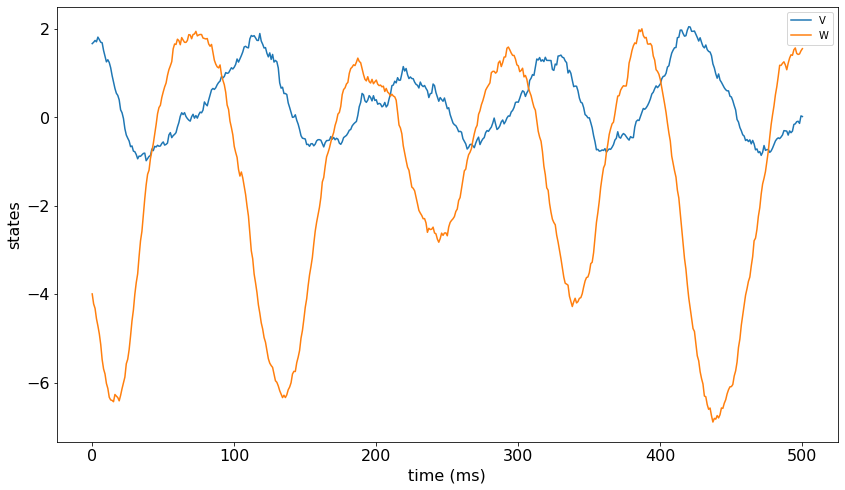

In [13]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states", fontsize=16)
plt.xlabel("time (ms)", fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

In [14]:
ncModel = NonCenteredModel(oscillator_model)

In [15]:
ncModel.load(f"{run_ids[idx]}.pkl")

In [16]:
ncModel.prior_stats

{'a': {'mean': 1.5, 'sd': 1.0},
 'b': {'mean': -12.0, 'sd': 6.0},
 'noise': {'mean': 0.05, 'sd': 0.1},
 'epsilon': {'mean': 0.0, 'sd': 1.0}}

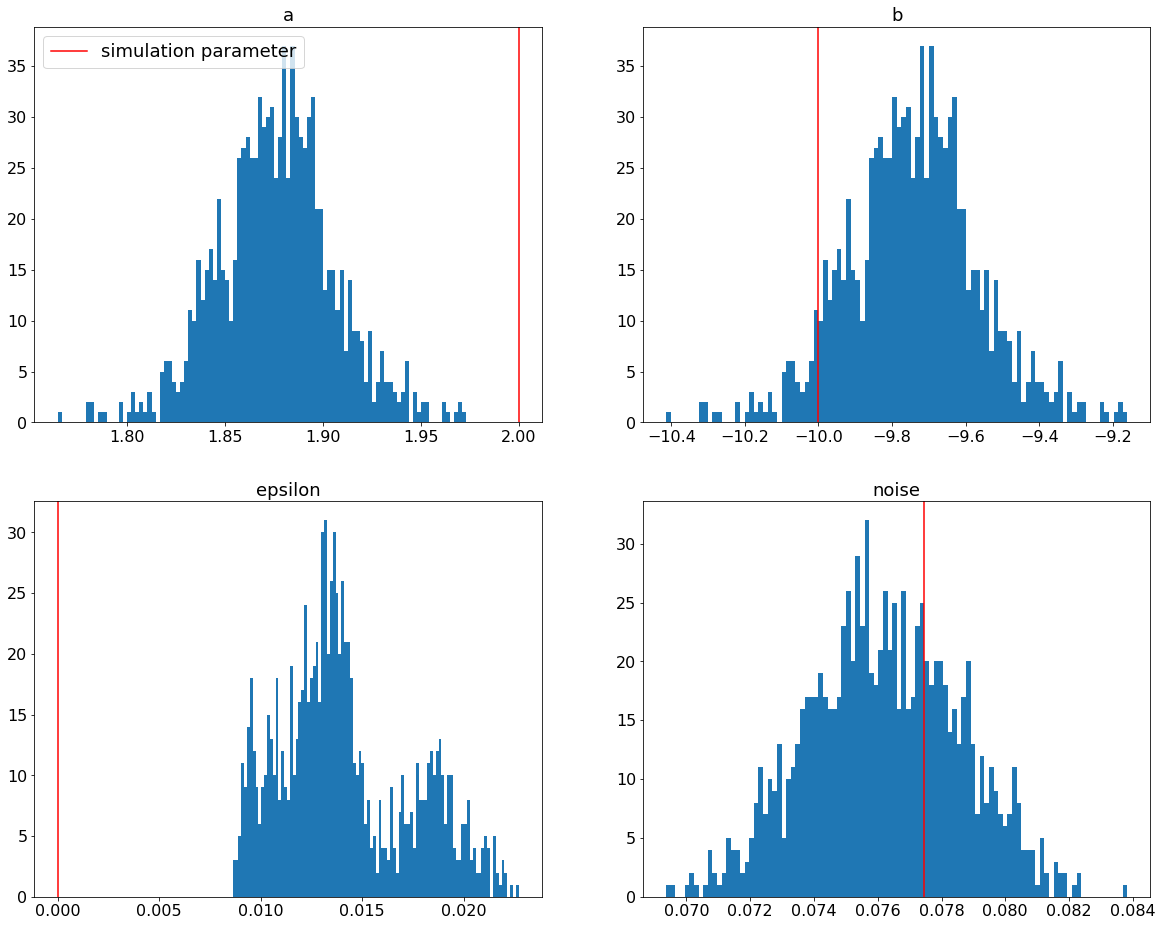

In [17]:
ncModel.plot_posterior_samples(
    init_params={"a": simulation_params["a_sim"],
                 "b": simulation_params["b_sim"],
                 "epsilon": 0.0, 
                 "noise": np.sqrt(2 * simulation_params["nsig"])
                }
)

In [18]:
n_draws = len(ncModel.inference_data.sample_stats.draw)
n_chains = len(ncModel.inference_data.sample_stats.chain)

In [19]:
posterior_x_obs = ncModel.inference_data.posterior_predictive.x_obs.values.reshape((n_chains*n_draws, *X.shape))

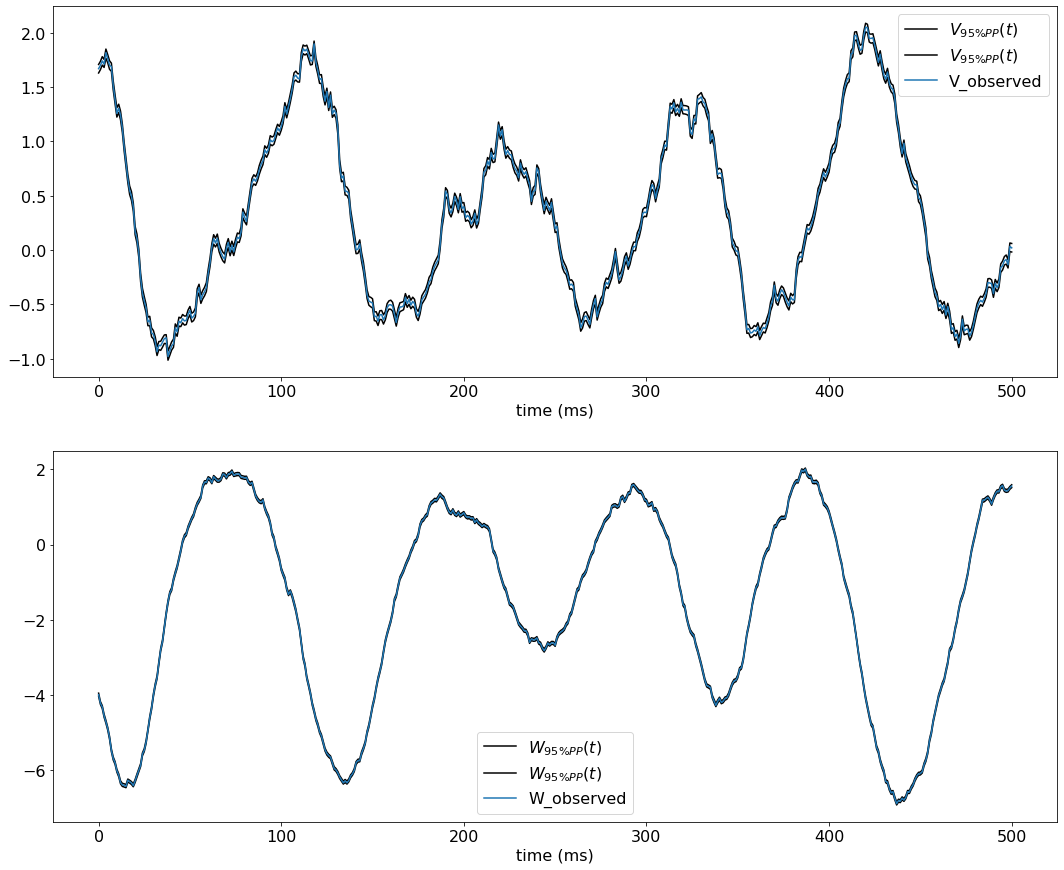

In [20]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
#axes3[0].plot(posterior_x_obs[0, :, 0, 0, 0])
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 1, 0, 0], label="W_observed")
#axes3[1].plot(posterior_x_obs[0, :, 1, 0, 0])
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [21]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [22]:
criteria

{'WAIC': 2503.3862645964364, 'LOO': 2299.1565761580473}

In [23]:
ncModel.summary[ncModel.summary["r_hat"] >= 1.2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.014,0.003,0.009,0.02,0.002,0.001,5.0,16.0,1.39


In [24]:
ncModel.summary.loc[["a", "b", "noise", "epsilon"]] #, "b", "c", "d", "I"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.876,0.030,1.817,1.931,0.003,0.002,127.0,281.0,1.01
b,-9.743,0.179,-10.098,-9.416,0.016,0.011,127.0,281.0,1.01
noise,0.076,0.002,0.072,0.081,0.000,0.000,44.0,199.0,1.03
epsilon,0.014,0.003,0.009,0.020,0.002,0.001,5.0,16.0,1.39


In [25]:
divergent = ncModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(ncModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.trace['mean_tree_accept'].mean())

Number of Divergent 45
Percentage of Divergent 9.0
Mean tree accept 0.9


In [26]:
print("Sampling time in hours:", ncModel.inference_data.sample_stats.sampling_time / 3600)

Sampling time in hours: 8.020956068171396
